Импортирую необходимые библиотеки

In [54]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as ss
import pingouin as pg
sns.set(style='whitegrid')
from datetime import datetime
import requests
from urllib.parse import urlencode

Вносим ссылки на файлы яндекс-диска

In [57]:
groups_url          = 'https://disk.yandex.ru/d/UhyYx41rTt3clQ'
groups_add_url      = 'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ'
active_students_url = 'https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ'
checks_url          = 'https://disk.yandex.ru/d/pH1q-VqcxXjsVA'

Считываю значения из яндекс-диска

In [60]:
base_url     = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
final_url    = base_url + urlencode(dict(public_key=groups_url))
response     = requests.get(final_url)
download_url = response.json()['href']
groups = pd.read_csv(download_url,sep=';')
groups.head(5)

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [61]:
base_url     = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
final_url    = base_url + urlencode(dict(public_key=groups_add_url))
response     = requests.get(final_url)
download_url = response.json()['href']
groups_add = pd.read_csv(download_url,sep=',')
groups_add.head(5)

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


In [62]:
base_url     = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
final_url    = base_url + urlencode(dict(public_key=active_students_url))
response     = requests.get(final_url)
download_url = response.json()['href']
active_studs = pd.read_csv(download_url,sep=',')
active_studs.head(5)

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [63]:
base_url     = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
final_url    = base_url + urlencode(dict(public_key=checks_url))
response     = requests.get(final_url)
download_url = response.json()['href']
checks = pd.read_csv(download_url,sep=';')
checks.head(5)

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


Информация о файлах

groups.csv – файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 

groups_add.csv – дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных

active_studs.csv – файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 

checks.csv – файл с информацией об оплатах пользователей в дни проведения эксперимента. 

Провожу проверку типов данных и заполненность таблиц

Удаляю дубликаты в данных

In [66]:
groups.head(5)

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [67]:
groups=groups.drop_duplicates()
groups.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74484 entries, 0 to 74483
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74484 non-null  int64 
 1   grp     74484 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [68]:
groups_add.head(5)

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


In [69]:
groups_add=groups_add.drop_duplicates()
groups_add.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      92 non-null     int64 
 1   grp     92 non-null     object
dtypes: int64(1), object(1)
memory usage: 1.6+ KB


In [70]:
active_studs.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [71]:
active_studs=active_studs.drop_duplicates()
active_studs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8341 entries, 0 to 8340
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   student_id  8341 non-null   int64
dtypes: int64(1)
memory usage: 65.3 KB


In [72]:
checks.head(5)

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [74]:
checks=checks.drop_duplicates()
checks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  541 non-null    int64  
 1   rev         541 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 8.6 KB


Исходя из анализа данных выше, делаю вывод о том, что отсутствуют пропуски в данных, тип данных не требует изменений

Произвожу соединение таблиц groups и groups_add в DF all_groups

Произвожу проверку на баги в данных
1. Наличие покупок при нулевой активности.<br>
   Для этого к таблице с чеками джойним таблицу с активностями и проверяем на пропуски. Пропуски дожны отсутствовать
2. Проверим отсутствие подозрительной активности-аномального числа покупок,аномальной суммы чеков

In [89]:
pd.merge(checks,active_studs,how='left',left_on='student_id', right_on='student_id').isnull().sum()#пропуски отсутствуют,багов нет

student_id    0
rev           0
dtype: int64

In [91]:
check_control=checks.groupby('student_id',as_index=False).agg({'rev':['count','sum']})
check_control.columns=['student_id','COUNT','SUM']
check_control.head(5)


,student_id,COUNT,SUM
0,1627,1,990.0
1,3185,1,690.0
2,25973,1,690.0
3,26280,1,690.0
4,100300,1,990.0


<Axes: xlabel='student_id', ylabel='SUM'>

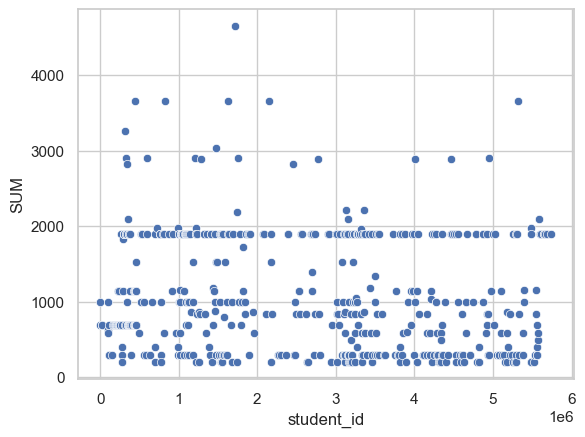

In [93]:
sns.scatterplot(data=check_control, y='SUM',x='student_id')#График 1 Анализ распределения суммы чека

<Axes: ylabel='SUM'>

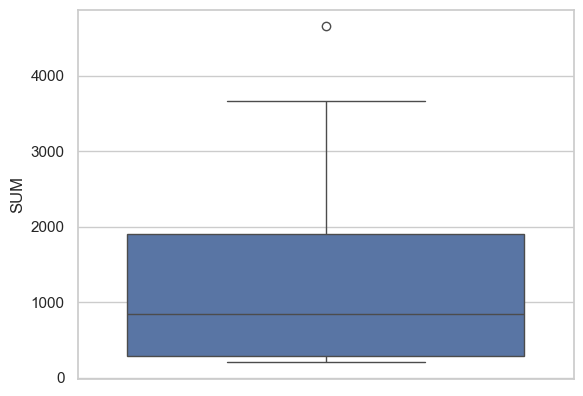

In [95]:
sns.boxplot(data=check_control, y='SUM')#График 2 Анализ распределения суммы чека

<Axes: xlabel='student_id', ylabel='COUNT'>

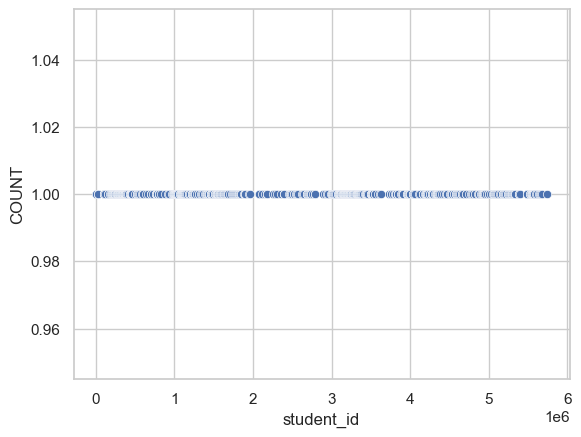

In [97]:
sns.scatterplot(data=check_control, y='COUNT',x='student_id')#График 3 Анализ распределения количества покупок

In [99]:
check_control.query('SUM>4000')

,student_id,COUNT,SUM
231,1711305,1,4650.0


Отсутствую признаки аномального количества покупок, и суммы чека. Так же отсутствует логическая противоречивость в данных.
Присутствует выброс суммы покупки для студента с id 1711305. Требуется дополнительный анализ по чеку данного клиента. В рамках текущего анализа и данных не производится. 

In [102]:
all_groups=pd.concat([groups,groups_add],ignore_index=True).drop_duplicates() 
all_groups.head(5)

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


Для оценки новой системы оплаты выберу следующие метрики:
1. Конверсия в оплату CR: отношение посетивших сайт к числу совершивших покупку
2. Средний чек покупки AOV:  = общая выручка за период / количество продаж за тот же период.

Данные метрики требуется рсчитать для двух групп: А, В

Определяю активных пользователей за время теста activ_group


In [106]:
activ_group=pd.merge(active_studs,all_groups,how='left', left_on='student_id', right_on='id')

In [108]:
activ_group=activ_group.drop('student_id',axis=1).drop_duplicates()

In [110]:
activ_group.head(5)

,id,grp
0,581585,A
1,5723133,A
2,3276743,B
3,4238589,A
4,4475369,B


Определяю пользователей, совершивших покупку из активной группы:

In [113]:
group_and_check=pd.merge(activ_group,checks, how='left', left_on='id', right_on='student_id')
group_and_check=group_and_check.drop('student_id', axis=1)


In [115]:
group_and_check['rev']=group_and_check['rev'].fillna(0)

In [117]:
group_and_check.head(5)

,id,grp,rev
0,581585,A,0.0
1,5723133,A,0.0
2,3276743,B,0.0
3,4238589,A,0.0
4,4475369,B,0.0


Произвожу расчет конверсии в оплату для обеих груп

In [120]:
CR_A=group_and_check.query('grp=="A"&rev!=0')['rev'].count()/group_and_check.query('grp=="A"')['rev'].count()
CR_B=group_and_check.query('grp=="B"&rev!=0')['rev'].count()/group_and_check.query('grp=="B"')['rev'].count()
print(f'Конверсия в оплату группы А равна {CR_A.round(3)}')
print(f'Конверсия в оплату группы В равна {CR_B.round(3)}')

Конверсия в оплату группы А равна 0.051
Конверсия в оплату группы В равна 0.046


Произвожу расчет среднего чека 

In [123]:
AOV_A=group_and_check.query('grp=="A"&rev!=0')['rev'].mean().round(3)
AOV_B=group_and_check.query('grp=="B"&rev!=0')['rev'].mean().round(3)
print(f'Средний чек группы А равна {AOV_A}')
print(f'Средний чек группы В равна {AOV_B}')

Средний чек группы А равна 933.59
Средний чек группы В равна 1257.879


Произвожу оценку роста среднего чека тестовой группы по сравнению с контрольной

In [126]:
DELTA_AOV=((AOV_B-AOV_A)*100/AOV_A).round(2)
print(f'Средний чек вырос на {DELTA_AOV}%') 

Средний чек вырос на 34.74%


Произвожу оценку изменения CR

In [129]:
DELTA_CR=((CR_B-CR_A)*100/CR_A).round(2)
print(f'Конверсия в оплату упала на {DELTA_CR}%')

Конверсия в оплату упала на -8.99%


Конверсия в оплату CR у группы В упала, при этом средний чек вырос

Построим гистограмму по размеру чека для группы А и В

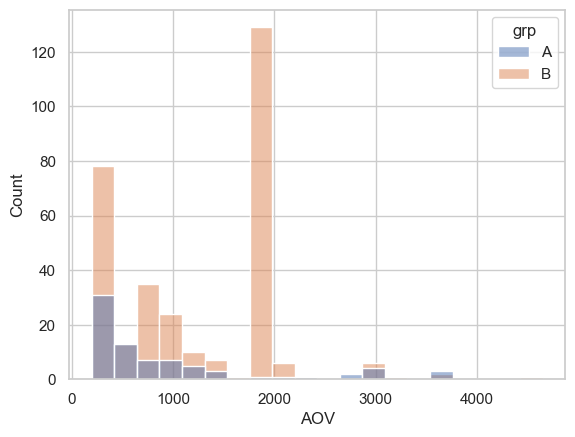

In [132]:
ax=sns.histplot(data=group_and_check.query('rev!=0'), x='rev',hue='grp',bins=20)
ax.set_xlabel('AOV')
plt.show()

Произведем оценку медианы для тестовой и контрольной группы графическим методом
Из графика видно, что AOV в тестовой группе существенно вырос

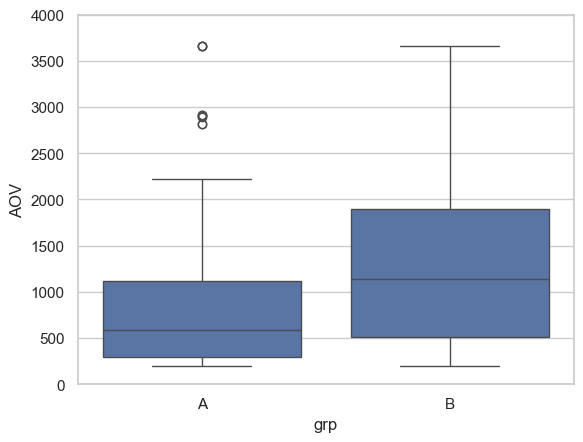

In [135]:
ac=sns.boxplot(data=group_and_check.query('rev!=0'), x='grp',y='rev')
plt.ylim(0,4000)
ac.set_ylabel('AOV')
plt.show()

Произведем оценку статистической значимости изменений AOV 

Сформулируем нулевую гипотезу:

Н0: Средний чек в тестовой и контрольной группе равны

Альтернативная гипотеза:

Н1: Средний чек в тестовой группе больше чем в контрольной

Требуется произвести сравнение средних сначений.
Произведем оценку распределения тестовой и контрольной группы (явлется ли нормальным), а так же проверим является ли дисперсии в двух группах равными

In [138]:
ss.levene(group_and_check.query('grp=="A"&rev!=0')['rev'],group_and_check.query('grp=="B"&rev!=0')['rev'])#тест Левена

LeveneResult(statistic=3.0756816999816055, pvalue=0.08025675761346926)

При проверке дисперсии тестом Левена pvalue=0.08, принимаем нулевую гипотезу о равенстве дисперсий в двух группах

In [141]:
ss.normaltest(group_and_check.query('grp=="A"&rev!=0')['rev'])#проверка распределения на нормальность контрольной группы

NormaltestResult(statistic=30.378419638487458, pvalue=2.531686880422046e-07)

Распределение AOV контрольной группы не является нормальным pvalue<0.05

In [144]:
ss.normaltest(group_and_check.query('grp=="B"&rev!=0')['rev'])#проверка распределения на нормальность контрольной группы

NormaltestResult(statistic=6.795662714490353, pvalue=0.033445723194625424)

Распределение AOV тестовой группы не является нормальным pvalue<0.05
Посчитаем размер выборки контрольной и тестовой группы

In [147]:
COUNT_A=group_and_check.query('grp=="A"&rev!=0')['rev'].count()
COUNT_B=group_and_check.query('grp=="B"&rev!=0')['rev'].count()
print(f'Размер выборки группы А={COUNT_A}, Размер выборки группы B={COUNT_B}')

Размер выборки группы А=78, Размер выборки группы B=314


В связи с тем, что размер выборки в контрольной и тестовой группе больше 30, можно использовать Т-тест, независимо от того  
что величины распределены не нормально. При этом дисперсия в обеих группах равна. Так как мы не знаем точно, выросла AOV или упала, применять буду двусторонний Т-тест

In [150]:
pg.ttest(group_and_check.query('grp=="A"&rev!=0')['rev'],group_and_check.query('grp=="B"&rev!=0')['rev'])

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-2.86169,106.981668,two-sided,0.00507,"[-548.94, -99.64]",0.39646,6.536,0.878211


При проведении Т-теста pvalue<0.05, следовательно делаем вывод о статистической значимости различий 
средних значений AOV тестовой и контрольной группы

Для оценки статистической значимости разницы CR тестовой и контрольной группы 
воспользуемся критерием Критерий хи-квадрат Пирсона (также известен как χ²-тест)
Сформулируем нулевую гипотезу:

Н0: CR не зависит от группы: тестовой и контрольной

Альтернативная гипотеза:

Н1: CR в тестовой и контрольной группе отличаются

Посчитаем частоту покупок и общее количество активных пользователей для тестовой и контрольной группы

In [154]:
group_and_check['rev']=group_and_check['rev'].apply(lambda x: 1 if x!=0 else 0)

In [156]:
xi_test=group_and_check.groupby('grp',as_index=False).agg({'rev':['count','sum']})
xi_test

grp   rev     
      count  sum
0   A  1538   78
1   B  6803  314

In [158]:
xi_test.columns=['grp','count','conv']
xi_test

,grp,count,conv
0,A,1538,78
1,B,6803,314


In [160]:
xi_test=xi_test.pivot_table(columns='grp')

In [162]:
xi_test

grp,A,B
conv,78.0,314.0
count,1538.0,6803.0


Проведем статистический тест

In [165]:
ss.chi2_contingency(xi_test['A'],xi_test['B'])

Chi2ContingencyResult(statistic=0.0, pvalue=1.0, dof=0, expected_freq=array([  78., 1538.]))

В связи с тем, что pvalue=1.0 нулевая мы не можем отвергнуть нулевую гипотезу, а значит CR в контрольной и тестовой
группе не отличаются.

Выводы по вопросам:

Вопрос: На какие метрики вы смотрите в ходе анализа и почему?
Ответ: При производстве анализа данных я использовал следующие метрики: конверсия посещения сайта в оплату CR, средний чек AOV

Вопрос: Имеются ли различия в показателях и с чем они могут быть связаны? Являются ли эти различия статистически значимыми?
Ответ:  Средний чек AOV вырос на 34.74%. Данный рост является статистически значимым поткритерий Манна-Уитни. 
Рост среднего чека связан с удобством и безопасностью новой системы оплаты.
Изменение CR составило -8.99%. Согласно критерия хи-квадрат Пирсона не изменения не являются статистически значимыми и связаны с размером выборки в контрольной и тестовой группе.

Вопрос: Стоит ли запускать новую механику на всех пользователей?
Ответ: Да, стоит запускать новую механику на всех пользователей. 

Задание 2
2.1 Очень усердные ученики.
2.1.1 Условие
Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной".
Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин.


Задание 2.2.2 Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов.NB! Под усердным студентом мы понимаем студента, который правильно решил 20 задач за текущий месяц. ОТВЕТ: SELECT st_id, count(st_id) as count FROM peas where correct=true and extract(year from timest)=extract(year from now()) group by st_id having count(st_id)>=20

2.2 Оптимизация воронки

2.2.1 Условие

Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 горошин в день. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты.
Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:

ARPU 
ARPAU 
CR в покупку 
СR активного пользователя в покупку 
CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике
ARPU считается относительно всех пользователей, попавших в группы.

Активным считается пользователь, за все время решивший больше 10 задач правильно в любых дисциплинах.

Активным по математике считается пользователь, за все время решивший 2 или больше задач правильно по математике.

ОТВЕТ: WITH ALL_STUDENT AS ( SELECT studs.st_id, studs.test_grp, first.money, CASE WHEN first.money IS NULL THEN 0 ELSE 1 END as FOR_CR, first.subject, ( SELECT COUNT(1) FROM peas WHERE peas.st_id = studs.st_id and peas.correct = true GROUP BY peas.st_id ) as COUNT_OF_PEAS, ( SELECT COUNT(1) FROM peas WHERE peas.st_id = studs.st_id AND peas.subject = 'Math' AND peas.correct = true GROUP BY peas.st_id ) as COUNT_OF_MATH FROM final_project_check as first RIGHT JOIN studs ON studs.st_id = first.st_id ), SECOND AS (SELECT ALL_STUDENT.test_grp, SUM(ALL_STUDENT.money) / COUNT(1) as ARPU, SUM(ALL_STUDENT.money) /( SELECT COUNT(1) FROM ALL_STUDENT WHERE ALL_STUDENT.COUNT_OF_PEAS > 10 ) AS ARPAU, SUM(ALL_STUDENT.FOR_CR)::float/COUNT(1) as CR_ALL_TO_SALE FROM ALL_STUDENT GROUP BY ALL_STUDENT.test_grp),

CR_ACTIVE_STUDENT AS (SELECT ALL_STUDENT.test_grp, SUM(ALL_STUDENT.for_cr)::float/COUNT(1) as CR_ACTIVE_STUDENT FROM ALL_STUDENT WHERE ALL_STUDENT.COUNT_OF_PEAS > 10 GROUP BY ALL_STUDENT.test_grp),

CR_ACTIVE_STUDENT_MATH AS (SELECT
    ALL_STUDENT.test_grp, 
    SUM(ALL_STUDENT.for_cr)::float/COUNT(1) as CR_ACTIVE_STUDENT_MATH
  FROM
    ALL_STUDENT 
  WHERE
    ALL_STUDENT.count_of_math > 2
    GROUP BY ALL_STUDENT.test_grp)
    
   SELECT SECOND.test_grp, SECOND.arpu,SECOND.arpau,SECOND.cr_all_to_sale,
   CR_ACTIVE_STUDENT.CR_ACTIVE_STUDENT,
   CR_ACTIVE_STUDENT_MATH.CR_ACTIVE_STUDENT_MATH
    FROM SECOND JOIN CR_ACTIVE_STUDENT ON CR_ACTIVE_STUDENT.test_grp=SECOND.test_grp
    JOIN CR_ACTIVE_STUDENT_MATH ON SECOND.test_grp=CR_ACTIVE_STUDENT_MATH.test_grp

Задание 3.1
Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.
ARPU-это метрика, которая используется для измерения среднего дохода от каждого пользователя за конкретный период времени.
ARPAU-средний платеж на всех активных пользователей. 
CR в покупку конверсия в покупку отношение общего числа пользователей к числу соверивших покупку
Конверсия в оплату активных пользователей CR: отношение посетивших сайт к числу совершивших покупку
Средний чек покупки AOV: = общая выручка за период / количество продаж за тот же период.

In [174]:
def add_tab(groups,groups_add):
    df=groups
    groups_add.columns=['id','grp']
    df=pd.concat([df,groups_add],ignore_index=True).drop_duplicates()
    active_studs['active']=1
    active_studs.columns=['id','active']
    checks.columns=['id','rev']
    df=pd.merge(df,checks,how='left',on=['id'])
    df=pd.merge(df,active_studs,on=['id'], how='left')
    df=df.fillna(0)
    #ARPU-это метрика, которая используется для измерения среднего дохода от каждого пользователя за конкретный период времени.
    #ARPU=SUM(df['rev'])/COUNT(df['id'])
    
    #Условия для фильтрации
    #Фильтры групп
    A=df['grp']=='A'
    B=df['grp']=='B'
    #Фильтр активых пользователей
    ACTIV=df['active']==1
    #Фильтр совершивших покупку
    REV=df['rev']!=0
    
    ARPU_A=df[A]['rev'].sum()/df[A]['id'].count()
    ARPU_B=df[B]['rev'].sum()/df[B]['id'].count()
    
    #ARPAU-средний платеж на всех активных пользователей. Активными будем считать пользователей, которые заходили на сайт(df['active']==1)
    ARPAU_A=df[A&ACTIV]['rev'].sum()/df[A&ACTIV]['id'].count()
    ARPAU_B=df[B&ACTIV]['rev'].sum()/df[B&ACTIV]['id'].count()


    #Средний чек покупки AOV: = общая выручка за период / количество продаж за тот же период.
    AOV_A=df[A&REV]['rev'].sum()/df[A&REV]['id'].count()
    AOV_B=df[B&REV]['rev'].sum()/df[B&REV]['id'].count()
    
    
    #CR в покупку конверсия в покупку отношение общего числа пользователей к числу соверивших покупку
    CR_A=df[A&REV]['id'].count()*100/df[A]['id'].count()
    CR_B=df[B&REV]['id'].count()*100/df[B]['id'].count()
    
    
    #Конверсия в оплату активных пользователей CRa: отношение посетивших сайт к числу совершивших покупку
    
    CRa_A=df[A&REV]['id'].count()*100/df[A]['active'].sum()
    CRa_B=df[B&REV]['id'].count()*100/df[B]['active'].sum()
    
    print(f'Cредний доход от каждого пользователя ARPU: группа А: {ARPU_A} группа B: {ARPU_B}')
    print(f'Cредний доход от активного пользователя ARPAU: группа А: {ARPAU_A} группа B: {ARPAU_B}')
    print(f'Средний чек покупки AOV: группа А: {AOV_A} группа B: {AOV_B}')
    print(f'Конверсия в покупку CR для всех пользователей: группа А: {CR_A} группа B: {CR_B}')
    print(f'Конверсия в покупку CR для всех активных пользователей: группа А: {CRa_A} группа B: {CRa_B}')
    df_metric={'Group': ['A', 'B'],
            'ARPU': [ARPU_A, ARPU_B],
            'ARPAU': [ARPAU_A, ARPAU_B],
            'AOV': [AOV_A, AOV_B],
            'CR': [CR_A, CR_B],
              'CRa':[CRa_A,CRa_B]} 
    df_metr=pd.DataFrame(df_metric)
    return df_metr


In [176]:
a=groups
b=groups_add
add_tab(a,b)

Cредний доход от каждого пользователя ARPU: группа А: 6.268018784455183 группа B: 8.03617059265568
Cредний доход от активного пользователя ARPAU: группа А: 47.34720416124838 группа B: 58.058798103777754
Средний чек покупки AOV: группа А: 860.7102803738318 группа B: 1108.8248930875575
Конверсия в покупку CR для всех пользователей: группа А: 0.7282379364323147 группа B: 0.7247465891822387
Конверсия в покупку CR для всех активных пользователей: группа А: 6.957087126137841 группа B: 6.379538438924004


,Group,ARPU,ARPAU,AOV,CR,CRa
0,A,6.268019,47.347204,860.710280,0.728238,6.957087
1,B,8.036171,58.058798,1108.824893,0.724747,6.379538


In [178]:
df_metr=add_tab(a,b)

Cредний доход от каждого пользователя ARPU: группа А: 6.268018784455183 группа B: 8.03617059265568
Cредний доход от активного пользователя ARPAU: группа А: 47.34720416124838 группа B: 58.058798103777754
Средний чек покупки AOV: группа А: 860.7102803738318 группа B: 1108.8248930875575
Конверсия в покупку CR для всех пользователей: группа А: 0.7282379364323147 группа B: 0.7247465891822387
Конверсия в покупку CR для всех активных пользователей: группа А: 6.957087126137841 группа B: 6.379538438924004


In [180]:
df=df_metr

In [182]:
def graf_metrics(df):
    sns.set(style='whitegrid')
    fig, axes = plt.subplots(1, 5, sharex=True, figsize=(15, 5))
    plt.tight_layout()
    fig.suptitle(f'Metrics review as of {datetime.now().strftime("%Y-%m-%d %H:%M")}')

    sns.barplot(ax=axes[0], y='ARPU', x='Group', data=df, hue='Group', legend=False)
    sns.barplot(ax=axes[1], y='ARPAU', x='Group', data=df, hue='Group', legend=False)
    sns.barplot(ax=axes[2], y='AOV', x='Group', data=df, hue='Group', legend=False)
    sns.barplot(ax=axes[3], y='CR', x='Group', data=df, hue='Group', legend=False)
    sns.barplot(ax=axes[4], y='CRa', x='Group', data=df, hue='Group', legend=False)

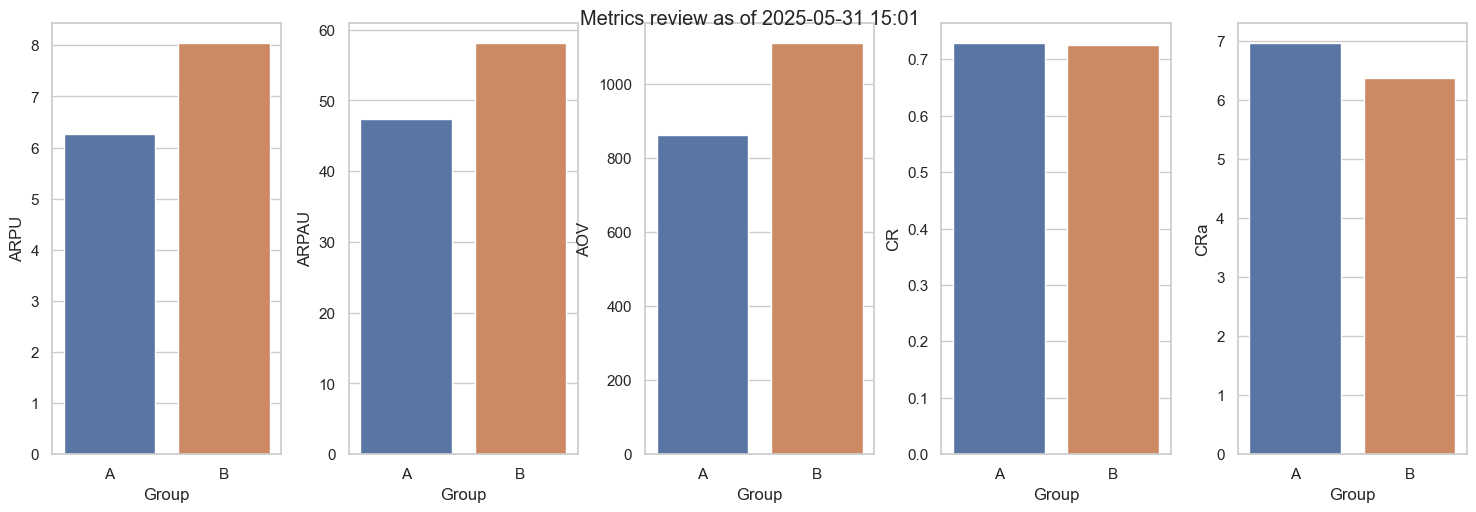

In [184]:
graf_metrics(df_metr)